In [1]:
import numpy as np
import boost_histogram as bh
from matplotlib import pyplot as plt

https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval

Wilson score interval:
$$
p_\text{min} = \frac{n_S + \frac 12 z^2}{n_S + n_F + z^2} - \frac{z}{n_S + n_F + z^2} \sqrt{\frac{n_S n_F}{n_S + n_F} + \frac{z^2}{4}}
$$
$$
p_\text{max} = \frac{n_S + \frac 12 z^2}{n_S + n_F + z^2} + \frac{z}{n_S + n_F + z^2} \sqrt{\frac{n_S n_F}{n_S + n_F} + \frac{z^2}{4}}
$$
with $n_S$ counts of selected events, $n_F$ counts of rejected events, $z$ number of sigmas ($z = 1$ for standard intervals).

In case of weighted events, the $n_i$ are the effective counts, computed as
$$
n_\text{effective} = \frac{\big(\sum_i w_i\big)^2}{\sum_i w^2_i}.
$$
In boost-histogram, this is computed as `n_eff = h.values() ** 2 / h.variances()` for a histogram `h` with `WeightedSum` storage.

In [2]:
def wilson_score_interval(n_s, n_f, z=1):
    n = n_s + n_f
    z2 = z * z
    center = (n_s + 0.5 * z2) / (n + z2)
    delta = z / (n + z2) * np.sqrt(n_s * n_f / n + 0.25 * z2)
    return center - delta, center + delta

In [3]:
p_truth = 0.2

rng = np.random.default_rng(1)

w_s = bh.accumulators.WeightedSum()
w_f = bh.accumulators.WeightedSum()

w = rng.exponential(10, size=100)
m = rng.uniform(size=len(w)) < p_truth

w_s.fill(w[m])
w_f.fill(w[~m])

WeightedSum(value=944.245, variance=24939.8)

efficiency = 0.16 - 0.05 + 0.06


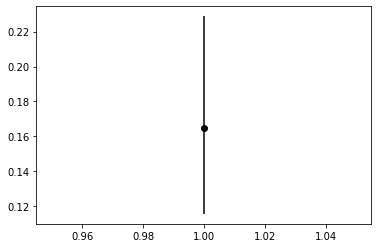

In [4]:
n_s = w_s.value ** 2 / w_s.variance
n_f = w_f.value ** 2 / w_f.variance

p = n_s / (n_s + n_f)
p_min, p_max = wilson_score_interval(n_s, n_f)
plt.errorbar([1], [p], [[p-p_min], [p_max-p]], fmt="ok")
print(f"efficiency = {p:.2f} - {p-p_min:.2f} + {p_max-p:.2f}")

Note that the error bar is asymmetric in general. This is especially noticable when p is close to 0 or 1.

Let's check with a toy simulation whether this uncertainty is correct.

efficiency(toys) = 0.20 +- 0.06


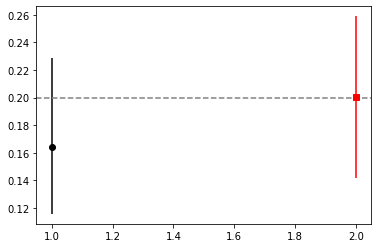

In [5]:
rng = np.random.default_rng(1)
p_toy = []
for itoy in range(1000):
    w = rng.exponential(10, size=len(w))
    m = rng.uniform(size=len(w)) < p_truth
    t_s = bh.accumulators.WeightedSum()
    t_f = bh.accumulators.WeightedSum()
    t_s.fill(w[m])
    t_f.fill(w[~m])
    p_toy.append(t_s.value / (t_s.value + t_f.value))
    
center = np.mean(p_toy)
delta = np.std(p_toy)

plt.errorbar([1], [p], [[p-p_min], [p_max-p]], fmt="ok")
plt.errorbar([2], [center], [[delta], [delta]], fmt="sr")
plt.axhline(p_truth, ls="--", color="0.5")
print(f"efficiency(toys) = {center:.2f} +- {delta:.2f}")

Ok, Check passed.